In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
%pip install -U tf-agents==0.13.0 pyvirtualdisplay
%pip install -U gym~=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]
%pip install pyglet==1.5.27

강화 학습에서 에이전트를 훈련하기 위해 작업 환경을 먼저 만들어야 하는데 훈련을 위한 최소한의 시뮬레이션 환경이 필요하다.

OpenAI 짐은 다양한 종류의 시뮬레이션 환경을 제공하여 에이전트를 훈련하고 비교하여 강화 학습 알고리즘을 개발할 수 있다.

CartPole 환경은 카트위에 놓인 막대가 넘어지지 않도록 왼쪽이나 오른쪽으로 가속할 수 있는 2D 시뮬레이션이다.

In [3]:
# OpenAI 짐 사용하기

import gym
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [4]:
obs, info = env.reset() # 항상 초기화해줘야 한다.
obs

array([ 0.02813748, -0.0339257 , -0.02275919,  0.04842805], dtype=float32)

이들은 각각 카트의 수평 위치, 카트의 속도, 막대의 각도, 막대의 각속도를 의미한다.

각각의 값은 양수일 때 x축 양의 방향, 오른쪽 방향, 수직에서 오른쪽으로 얼마나 회전했는지, 시계방향을 의미한다.

In [5]:
img = env.render()
img.shape

(400, 600, 3)

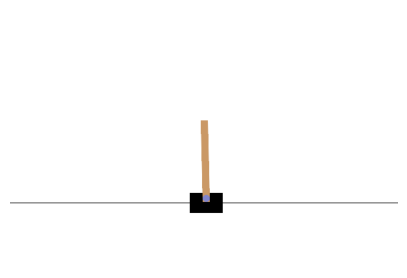

In [6]:
# 카트와 막대 그림

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [7]:
env.action_space

Discrete(2)

action_space가 Discrete(2)라는 뜻은 가능한 행동이 정수 0과 1만 있다는 뜻이다.

In [8]:
action = 1  # 오른쪽으로 가속
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02745897,  0.16151507, -0.02179063, -0.25134784], dtype=float32)

obs: 새로운 관측값이다

reward: 이 환경에서 얼마나 보상을 받았는지이다

done: True일 경우 게임 한 판이 끝난다

truncated: 범위를 벗어난 위치에서 절단 조건이 만족되는지 여부이다

info: 디버깅이나 훈련에 유용한 추가적인 정보 담는 부분이다

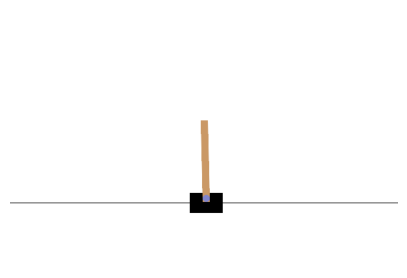

In [9]:
plot_environment(env)
plt.show()

In [10]:
if done or truncated:
    obs, info = env.reset()

In [11]:
# 간단한 하드 코딩 정책 - 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 움직이고, 오른쪽으로 기울어지면 반대로 움직임

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

최대로 막대를 유지한 스텝 횟수가 63회이다.

에이전트가 막대를 200 스텝 이상 유지해야 해결된 것으로 간주하기 때문에 아직 많이 부족한 것을 볼 수 있다.

In [12]:
# 에피소드 시각화

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [13]:
frames = []

obs, info = env.reset()
for step in range(200):
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    if done:
        break

plot_animation(frames)

In [14]:
# 신경망 정책

n_inputs = 4

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

관측을 입력으로 받고 각 관측에 대해 선택할 행동의 확률을 출력하는 신경망은 행동을 선택하기 위해 각 행동의 확률을 추정한다.

이 추정된 확률에 따라 랜덤하게 행동을 선택하는데, Cart-Pole 환경의 경우 두 개의 가능한 행동이 있기 때문에 하나의 출력 뉴런만 있으면 된다.

이 뉴런에서 행동이 0 즉, 왼쪽으로 갈 확률 p를 출력한다.

In [15]:
def render_policy_net(model, n_max_steps=200):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, truncated, info = env.step(action)
        if done:
            break
    env.close()
    return frames

frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 120ms/step


In [16]:
# 같은 신경망 동시에 여러개 다른 환경에서 실행

n_environments = 50
n_iterations = 500

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]

observations = []
for env in envs:
    obs, info = env.reset()
    observations.append(obs)

optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, truncated, info = env.step(actions[env_index][0])
        if not done:
            observations[env_index] = obs
        else:
            obs, info = env.reset()
            observations[env_index] = obs

for env in envs:
    env.close()

frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 31ms/step


확실히 이전에 비해 많이 향상된 것을 볼 수 있다.

In [17]:
# 하나의 스텝 플레이
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis]) # 왼쪽으로 이동할 확률
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

# 여러 스텝 플레이
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [18]:
# 할인된 보상 계산
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

# 할인된 보상 정규화
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [19]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

각각 행동의 보상이 10, 0, -50이고 0.8의 할인 계수를 가지는 경우이다.

이를 보면 세 번째 행동은 -50을 받고, 두 번째 행동은 0 + 0.8(-50) = -40이다.

그리고 첫 번째 행동은 $10 + (0.8) * 0 + (0.8)^2 * (-50) = -22$를 받는다.

In [20]:
# 정책 그레디언트

n_iterations = 50
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [21]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 39ms/step


In [22]:
# 마르코프 연쇄

# 각각 s_idx에서 s_idx로의 전이 확률
transition_probabilities = [[0.7, 0.2, 0.0, 0.1],
                            [0.0, 0.0, 0.9, 0.1],
                            [0.0, 1.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 1.0]]

n_max_steps = 50

# s3에 도달하면 종료
def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 0 0 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 0 0 0 3 
States: 0 0 0 1 3 
States: 0 3 
States: 0 3 
States: 0 0 0 3 
States: 0 0 0 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 1 2 1 3 
States: 0 0 0 0 0 0 0 3 


각각 s에서 a를 선택했을 때 s'으로 가는것이다.

예를들어 s0에서 a0를 하는 경우를 보면 상태 s0에서 행동 a0가 선택되면 0.7의 확률로 상태 s0로 가고 +10 보상을 받는다.

또는 0.3의 확률로 상태 s1으로 가고 보상이 없다.

상태 s2로는 이동하지 않는다.

따라서 전이 확률은 [0.7, 0.3, 0.0]이고, 보상은 [10, 0, 0]이다.

In [23]:
# 마르코프 결정 과정

transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]

In [24]:
# Q-가치 반복

Q_values = np.full((3, 3), -np.inf) # 불가능한 행동은 -np.inf으로
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 가능한 행동은 0으로

In [25]:
gamma = 0.90  # 할인 계수

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1)
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

Q-가치는 이와 같은데 s0에서 a0을 선택했을 때 보상의 기대는 약 18.9이다.

In [26]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

할인 계수 0.9를 사용했을 때 MDP의 최적 정책은 상태 s0에서 행동 a0를 선택하고, 상태 s1에서 행동 a0를 선택하고, 마지막으로 상태 s2에서 행동 a1을 선택하는 것이다.

In [27]:
# 할인 계수가 0.95일 때

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0
gamma = 0.95

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [28]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

할인 계수가 커서 에이전트가 미래에 더 많은 가치를 두기 때문에 미래 보상을 얻기 위해 당장의 불이익을 감내하는 방향이 최선임을 볼 수 있다.

In [29]:
# 환경 탐색 - 에이전트가 한 행동 실행하고 결과 상태와 보상 얻음
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

# 탐험 정책
def exploration_policy(state):
    return np.random.choice(possible_actions[state]) # 랜덤한 정책

이제 앞에서와 같이 Q-가치를 초기화하고 Q-러닝 알고리즘을 실행해 보죠:

In [30]:
# Q-러닝

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # 초기 학습률
decay = 0.005 # 학습률 감쇄
gamma = 0.90 # 할인 계수
state = 0 # 초기 상태
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # 다음 스텝의 그리디 정책
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)
Q_values

array([[18.53210101, 16.40818975, 13.05279555],
       [ 0.        ,        -inf, -8.836865  ],
       [       -inf, 48.60653672,        -inf]])

In [31]:
np.argmax(Q_values, axis=1) # 각 상태에 대한 최적의 행동

array([0, 0, 1])

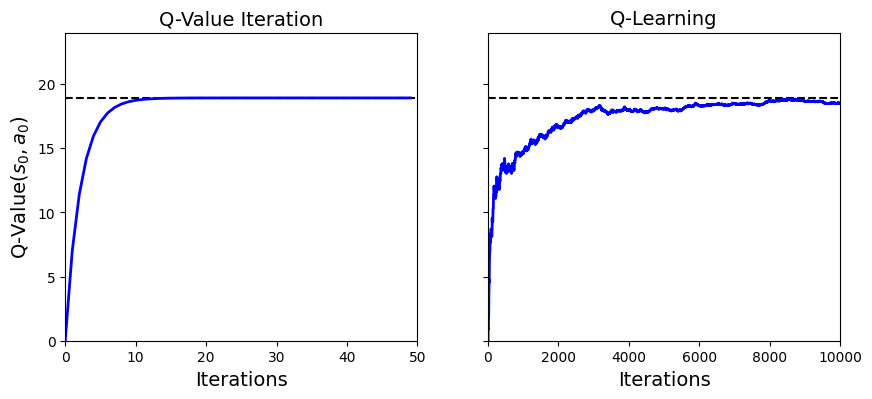

In [32]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

plt.show()

Q-가치 반복과 Q-러닝을 비교해보면 가치 반복의 경우 항상 가장 높은 가치를 가진 행동을 선택하여 위와 같은 결과가 나왔다.

반면 Q-러닝의 경우 훈련된 정책을 바탕으로 완전히 랜덤하게 정책이 적용되었다.

그렇지만 가치 반복과 비슷한 결과로 수렴하는 것을 볼 수 있다.

따라서 무작위로 행동하는것을 보는것 만으로도 최적의 정책을 학습하는 능력이 있다는 것을 볼 수 있다.

In [33]:
# 심층 Q-네트워크

env = gym.make("CartPole-v1", render_mode="rgb_array")
input_shape = [4]
n_outputs = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [34]:
# ε-그리디 정책

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()

In [35]:
# 재생 버퍼

from collections import deque

replay_memory = deque(maxlen=2000)

In [36]:
# 경험
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

# 1회 실행
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [37]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error # 손실 함수

def training_step(batch_size):
    experiences = sample_experiences(batch_size) # 경험 배치 샘플링
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1) # 다음 상태에 대한 최대 Q-가치만 저장
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
rewards = []
best_score = 0

for episode in range(400):
    obs, info = env.reset()
    for step in range(20):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

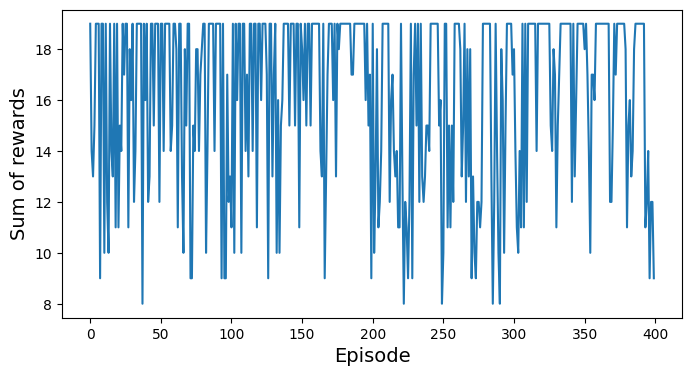

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [40]:
# 더블 DQN

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [41]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1) # 온라인 모델을 사용하여 최선의 행동 선택
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(400):
    obs, info = env.reset()
    for step in range(20):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

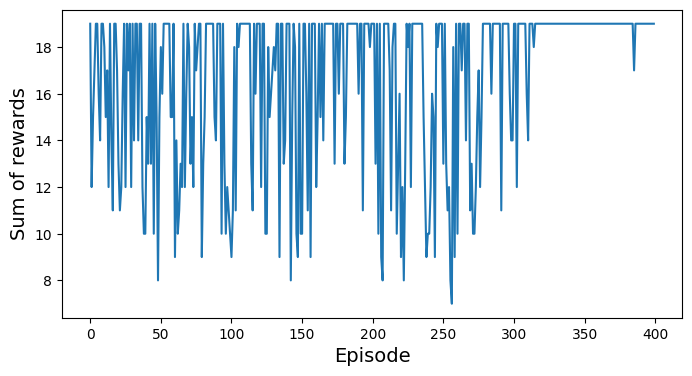

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [47]:
state, info = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info, truncated = env.step(action)
    if done:
        break
    img = env.render()
    frames.append(img)

plot_animation(frames)

In [48]:
# 듀얼링 더블 DQN

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [49]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(400):
    obs, info = env.reset()
    for step in range(20):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

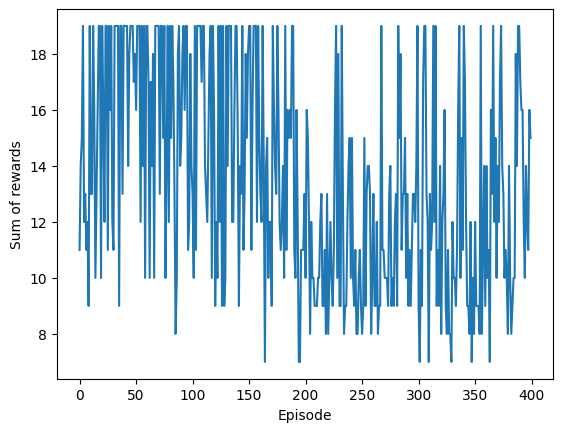

In [51]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [52]:
state, info = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info, truncated = env.step(action)
    if done:
        break
    img = env.render()
    frames.append(img)

plot_animation(frames)

In [53]:
env.close()

Deque와 로테이팅 리스트비교

deque는 append의 속도는 빠르지만 재생 메모리가 클 경우 랜덤 접근은 느리다.

In [54]:
mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in np.random.randint(1000000, size=5)]

[840388, 540832, 50936, 714648, 219590]

In [55]:
%timeit mem.append(1)

124 ns ± 23.8 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [56]:
%timeit [mem[i] for i in np.random.randint(1000000, size=5)]

281 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [57]:
# 로테이팅 리스트

class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [58]:
mem = ReplayMemory(max_size=1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

<ipython-input-57-9e1f625df9e2>:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.buffer = np.empty(max_size, dtype=np.object)


array([897803, 448285, 154841, 919436, 169989], dtype=object)

In [59]:
%timeit mem.append(1)

602 ns ± 5.49 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [60]:
%timeit mem.sample(5)

28.2 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
